# The Reference Elevation Model of Antarctica, REMA. 

This digital elevation model is freely availible for download from the University of Minnesota's Polar Geospatial Center:
https://www.pgc.umn.edu/data/rema/

This example uses a version of the 8-m mosaic product (total size ~1TB) that is stored as cloud-optimized geotiffs in a google bucket:
gs://ldeo-glaciology/REMA

Howat, I. M., Porter, C., Smith, B. E., Noh, M.-J., and Morin, P.: The Reference Elevation Model of Antarctica, The Cryosphere, 13, 665-674, https://doi.org/10.5194/tc-13-665-2019, 2019.

### 1. Import packages and define functions

In [1]:
from dask.distributed import Client
import dask_gateway
import numpy as np
import xarray as xr
from matplotlib import pyplot as plt
from rasterio import RasterioIOError
from tqdm.autonotebook import tqdm

<ipython-input-1-525a08df9049>:7: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


### 2. Start a cluster 

In [2]:
from dask.distributed import Client
import dask_gateway
gateway = dask_gateway.Gateway()
cluster = gateway.new_cluster()

In [3]:
cluster.scale(48)
client = Client(cluster)
cluster

to view the dask scheduler dashboard either click the link above, or copy the link in to the serach bar in the dask tab on the right, prefixing it with https://us-central1-b.gcp.pangeo.io/ - then you get access to tools for monitoring activity of the cluster, which can be docked in this window. 

### 3. 'Lazily' load some REMA tiles 
Change the numbers being fed to `range` to change the tiles that are being loaded.
Chunk size is also very important https://docs.dask.org/en/latest/array-best-practices.html#select-a-good-chunk-size. Change the number being fed to `chunks` to experiment with how this effects computation time.

In [4]:
uri_fmt = 'gs://pangeo-pgc/8m/{i_idx:02d}_{j_idx:02d}/{i_idx:02d}_{j_idx:02d}_8m_dem_COG_LZW.tif'

rows = []
for i in range(40, 36, -1): 
    cols = []
    for j in tqdm(range(20,24)):
        uri = uri_fmt.format(i_idx=i, j_idx=j)
        try:
            dset = xr.open_rasterio(uri, chunks=5000)
            dset_masked = dset.where(dset > 0.0)
            cols.append(dset_masked)
            #print(uri)
        except RasterioIOError:
            pass
    rows.append(cols)
dsets_rows = [xr.concat(row, 'x') for row in rows]
ds = xr.concat(dsets_rows, 'y', )

ds = ds.squeeze()                          # remove the singleton dimension 
ds.name = 'elevation above sea level [m]'  # add a name for the dataarray
ds.attrs['units'] = 'm a.s.l.'             # add units
ds.attrs['standard_name'] = 'elevation'    # at a standard name to teh attributes 
ds = ds.drop('band')                       # drop the band coordinate 
ds.attrs['long_name'] = 'elevation above sea level'
ds

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

<xarray.DataArray 'elevation above sea level [m]' (y: 50000, x: 50000)>
dask.array<getitem, shape=(50000, 50000), dtype=float32, chunksize=(5000, 5000), chunktype=numpy.ndarray>
Coordinates:
  * y        (y) float64 1e+06 1e+06 1e+06 1e+06 ... 6e+05 6e+05 6e+05 6e+05
  * x        (x) float64 -1.1e+06 -1.1e+06 -1.1e+06 ... -7e+05 -7e+05 -7e+05
Attributes:
    transform:           (8.0, 0.0, -1100000.0, 0.0, -8.0, 1000000.0)
    crs:                 +init=epsg:3031
    res:                 (8.0, 8.0)
    is_tiled:            1
    nodatavals:          (-9999.0,)
    scales:              (1.0,)
    offsets:             (0.0,)
    AREA_OR_POINT:       Area
    OVR_RESAMPLING_ALG:  NEAREST
    units:               m a.s.l.
    standard_name:       elevation
    long_name:           elevation above sea level

### 4. Plot this subset of the data
(making use of coarsen to avoid downloading 5GB)

CPU times: user 317 ms, sys: 38.5 ms, total: 355 ms
Wall time: 57.9 s


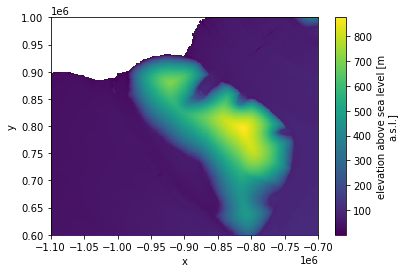

In [5]:
%%time
ds_coarse = ds.coarsen(y=100,x=100,boundary='trim').mean().persist();
ds_coarse.attrs['units'] = 'm a.s.l.'             # add units
ds_coarse.attrs['standard_name'] = 'elevation'    # at a standard name to teh attributes 
ds_coarse.attrs['long_name'] = 'elevation above sea level'
ds_coarse.plot();


This is great! To download these data, apply a moving average (coarsening) and  plot them would have take much longer than the ~30s it took to run the cell above. 

However, this is lower resolution data - what if we want the full resolution along a profile?

### 5. Extract a profile across the DEM

CPU times: user 55.6 ms, sys: 2.08 ms, total: 57.6 ms
Wall time: 8.85 s


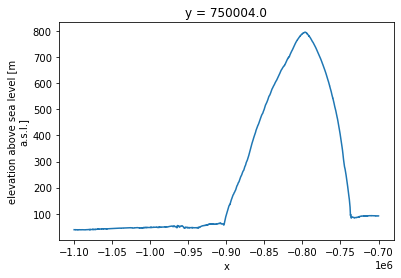

In [6]:
%%time
ds.sel(y = 750000, method='nearest').plot()

...again this was much quicker than analyzing these data in a conventional non-cloud-based way.

### 6. try this yourself!
To try this yourself the easiest way it to click the binder link in the top left of this page. 
This will spin up a temporary cloud computing environment with this notebook fully executable. 

If you are interested in getting more into this cloud-based way of working, go to https://us-central1-b.gcp.pangeo.io/ and sign up with a github (you may need to wait to be given access). Once you in, you will have access to a binderlab that gives you the choice of opening notebooks or a terminal. Open a terminal and clone the repo that contains this notebook and several others by entering `git clone https://github.com/ldeo-glaciology/pangeo-glaciology-examples.git` in the terminal. 

In [7]:
#cluster.shutdown()